# Land Cover Type Classification with PyTorch

This notebook serves as a starting point for your machine learning project on land cover type classification.

The task at hand involves classifying land cover types, such as 'Forest,' 'River,' 'Highway,' and more, based on satellite images. The dataset consists of images labeled with their corresponding land cover types. The goal is to train a machine learning model that can accurately predict the land cover type of new, unseen images.

In this notebook, you'll find code snippets to load and visualize the data, providing insights into the images and their labels.

## Build Your Model

You have the freedom to choose the architecture or model for your land cover classification task. Whether you opt for a simple convolutional neural network (CNN) or explore transfer learning with pre-trained models, the notebook provides a flexible starting point. Experiment with different architectures to achieve the best performance.

## Model Training and Evaluation

Once your model is defined, the notebook guides you through the process of training it on the dataset. Additionally, it includes code to evaluate the model's performance on the validation and test sets.

Feel free to modify, experiment, and enhance the provided code. Happy coding !

Please submit your weekly assignments to me via [email](mailto:elmontassir@cerfacs.fr) to receive your score on the test set.



# Data

In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import tarfile
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [33]:
# Check GPU availability
if torch.cuda.is_available():
  device = torch.device("cuda")
  print("You are on GPU !")
else:
  print('Change the runtime to GPU or continue with CPU, but this should slow down your trainings')
  device = torch.device("cpu")

You are on GPU !


In [34]:
# Loading the dataset
!wget -nv https://cerfacs.fr/opendata/cours/data/TRAIN.tar
!wget -nv https://cerfacs.fr/opendata/cours/data/TEST.tar
!wget -nv https://cerfacs.fr/opendata/cours/data/y_train.npy

2023-12-29 13:48:40 URL:https://cerfacs.fr/opendata/cours/data/TRAIN.tar [44851200/44851200] -> "TRAIN.tar.1" [1]
2023-12-29 13:48:43 URL:https://cerfacs.fr/opendata/cours/data/TEST.tar [15687680/15687680] -> "TEST.tar.1" [1]
2023-12-29 13:48:44 URL:https://cerfacs.fr/opendata/cours/data/y_train.npy [1600128/1600128] -> "y_train.npy.1" [1]


In [35]:
# Using tarfile to create np arrays
def extract_files(dataset):
    tar = tarfile.open(dataset+'.tar', 'r')
    names = tar.getmembers()[:]
    images = [tar.extractfile(name) for name in names]
    return np.array([np.array(Image.open(image)) for image in images])

In [36]:
X_train = extract_files('TRAIN')
X_test = extract_files('TEST')
y_train = np.load('y_train.npy').reshape(-1, 1)
print("Train data : ",X_train.shape)
print("Train labels", y_train.shape)
print("Test data : ",X_test.shape)

Train data :  (20000, 64, 64, 3)
Train labels (20000, 1)
Test data :  (7000, 64, 64, 3)


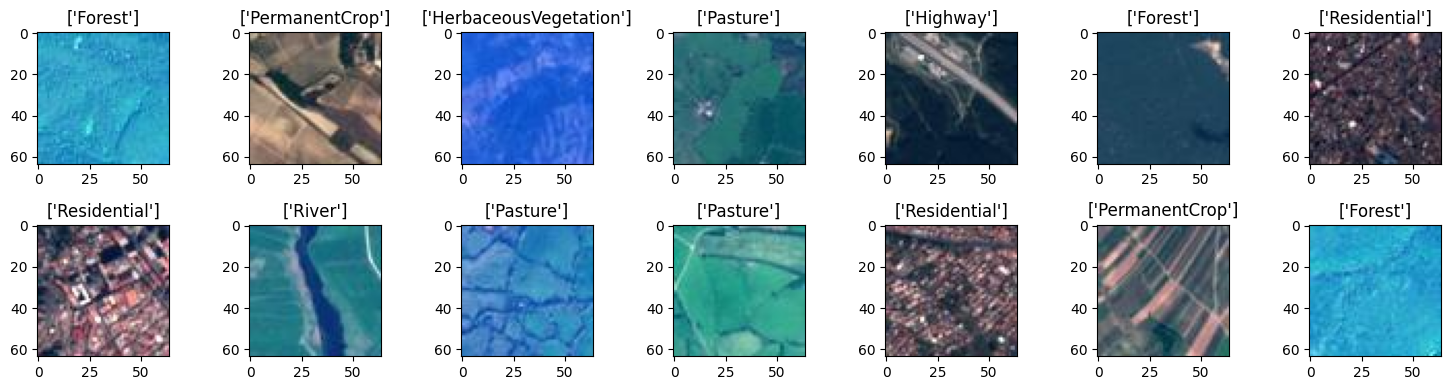

In [37]:
# Display data samples
fig, axes = plt.subplots(2, 7, figsize=(15, 4))
axes = axes.ravel()
for i in range(14):
    axes[i].imshow(X_train[i])
    axes[i].set_title(y_train[i])
plt.tight_layout()

There are 10 possible classes for each image (only one per image is correct):

  - 'AnnualCrop'
  - 'Forest'
  - 'HerbaceousVegetation'
  - 'Highway'
  - 'Industrial'
  - 'Pasture'
  - 'PermanentCrop'
  - 'Residential'
  - 'River'
  - 'SeaLake'

We could simply code an integer value for each: 'AnnualCrop' = 0, 'Forest' = 1, etc... This is known as "Ordinal Encoding", and has some drawbacks, e.g. if the network is unsure whether it is class 0 or 2, it could end up saying 1, which is another class altogether. When categories have a natural order, ordinal encoding can be a good way to go. Here, this is not the case.

The most classical way to convert the type of labels here to numeric values is through [**one-hot encoding**](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-categorical-features). In this process, the label is converted to a vector with length the number of possible labels, and only the one matching the true label is set to 1, all others are set to 0.

|                 | Type1 | Type2 | Type3 |   | Label Vector |
|-----------------|:-----:|:-----:|:-----:|---|:------------:|
| Sample1: Type 2 |   0   |   1   |   0   |   |   [0, 1, 0]  |
| Sample2: Type 2 |   0   |   1   |   0   |   |   [0, 1, 0]  |
| Sample3: Type 1 |   1   |   0   |   0   |   |   [1, 0, 0]  |
| ...             |       |       |       |   |              |

Scikit-learn has a useful class for this, [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html), which does this automatically. More importantly, it remembers the encoding, and you can use it again after making your final predictions te *decode* them back to text labels, as expected by the competition.

In [38]:
# Convert labels to one-hot encoding
encoder = OneHotEncoder()
y_train = encoder.fit_transform(y_train).toarray()

# Model

Note: the images here are encoded with 8-bit integers, *i.e.* between 0 and 255. A normalization is needed.

In [39]:
# Prepare data for training
X_train, X_test = X_train/255, X_test/255
mean = np.mean(X_train, axis=(0, 1, 2))
std = np.std(X_train, axis=(0, 1, 2))
print(mean)
print(std)

[0.29088279 0.41201959 0.48920503]
[0.2240432  0.17601508 0.21699366]


The normalization coefficients for the mean and standard deviation are commonly used for image data normalization within the range of [0, 255] or [0, 1]. This process brings pixel values into a standard range centered around zero, facilitating the acceleration of neural network training. In this case, we begin by dividing by 255 to scale values to [0, 1]. Subsequently, subtracting the mean centers the range around zero, and dividing by the standard deviation reduces the range to a centered Gaussian distribution, promoting stability.

Normalization coefficients may vary depending on the dataset, image characteristics, and network architecture. Experimenting with different strategies is common in model development. For specific datasets, calculating the mean and standard deviation directly from the training data can provide a good normalization.

In [40]:
# Assuming X_train and y_train are PyTorch tensors
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors and normalize images
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

X_train_tensor = torch.stack([transform(img) for img in X_train]).float()
X_valid_tensor = torch.stack([transform(img) for img in X_valid]).float()
X_test_tensor = torch.stack([transform(img) for img in X_test]).float()
y_train_tensor = torch.from_numpy(y_train)
y_valid_tensor = torch.from_numpy(y_valid)

In [41]:
# Define the CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.b1 = nn.BatchNorm2d(32)

        # ... (add more layers as needed)
        # self.fc = nn.Linear(..., 10)  # Output has 10 classes
        # YOUR CODE HERE
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.b2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.b3 = nn.BatchNorm2d(128)

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.b4 = nn.BatchNorm2d(256)

        self.global_pooling = nn.AdaptiveAvgPool2d(1)

        self.fc1 = nn.Linear(256, 128)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(64, 10)




    def forward(self, x):

        x = self.b1(F.relu(self.conv1(x)))

        x = self.pool1(x)

        x = self.b2(F.relu(self.conv2(x)))
        x = self.pool2(x)

        x = self.b3(F.relu(self.conv3(x)))
        x = self.pool3(x)

        x = self.b4(F.relu(self.conv4(x)))
        x = self.pool4(x)

        x = self.global_pooling(x)
        x = x.view(-1, 256)


        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)

        return x

In [42]:
from torch.optim.lr_scheduler import StepLR

# Instantiate the model
model = CNN().to(device)

# Print the model architecture
print(model)



# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()

lr = 0.001
w_d = 1e-4

optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=w_d)
scheduler = StepLR(optimizer, step_size=5, gamma=0.9)

# Training loop
num_epochs = 30
batch_size = 128

train_dataset = TensorDataset(X_train_tensor, y_train_tensor.argmax(dim=1))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor.argmax(dim=1))
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (b1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (b2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (b3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (b4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running

In [43]:
for epoch in range(num_epochs):
    scheduler.step()
    model.train()
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


    true_labels = []
    predicted_labels = []
    model.eval()
    with torch.no_grad():
        valid_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in valid_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

    accuracy = correct / total
    print(f'Epoch {epoch + 1}/{num_epochs}, Validation Loss: {valid_loss / len(valid_loader):.3f}, Accuracy: {100*accuracy:.2f}%')

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 1/30, Validation Loss: 0.835, Accuracy: 69.92%
Epoch 2/30, Validation Loss: 0.636, Accuracy: 77.30%
Epoch 3/30, Validation Loss: 0.565, Accuracy: 79.45%
Epoch 4/30, Validation Loss: 0.524, Accuracy: 81.97%
Epoch 5/30, Validation Loss: 0.437, Accuracy: 84.97%
Epoch 6/30, Validation Loss: 0.425, Accuracy: 86.50%
Epoch 7/30, Validation Loss: 0.401, Accuracy: 86.85%
Epoch 8/30, Validation Loss: 0.391, Accuracy: 86.90%
Epoch 9/30, Validation Loss: 0.366, Accuracy: 89.08%
Epoch 10/30, Validation Loss: 0.331, Accuracy: 89.62%
Epoch 11/30, Validation Loss: 0.312, Accuracy: 90.48%
Epoch 12/30, Validation Loss: 0.289, Accuracy: 91.07%
Epoch 13/30, Validation Loss: 0.446, Accuracy: 89.03%
Epoch 14/30, Validation Loss: 0.324, Accuracy: 90.92%
Epoch 15/30, Validation Loss: 0.397, Accuracy: 89.53%
Epoch 16/30, Validation Loss: 0.335, Accuracy: 90.72%
Epoch 17/30, Validation Loss: 0.328, Accuracy: 92.17%
Epoch 18/30, Validation Loss: 0.340, Accuracy: 90.77%
Epoch 19/30, Validation Loss: 0.349, 

In [44]:
from sklearn.metrics import precision_recall_fscore_support

# Calculate precision, recall, F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1_score:.4f}')


Precision: 0.9315
Recall: 0.9305
F1-score: 0.9304


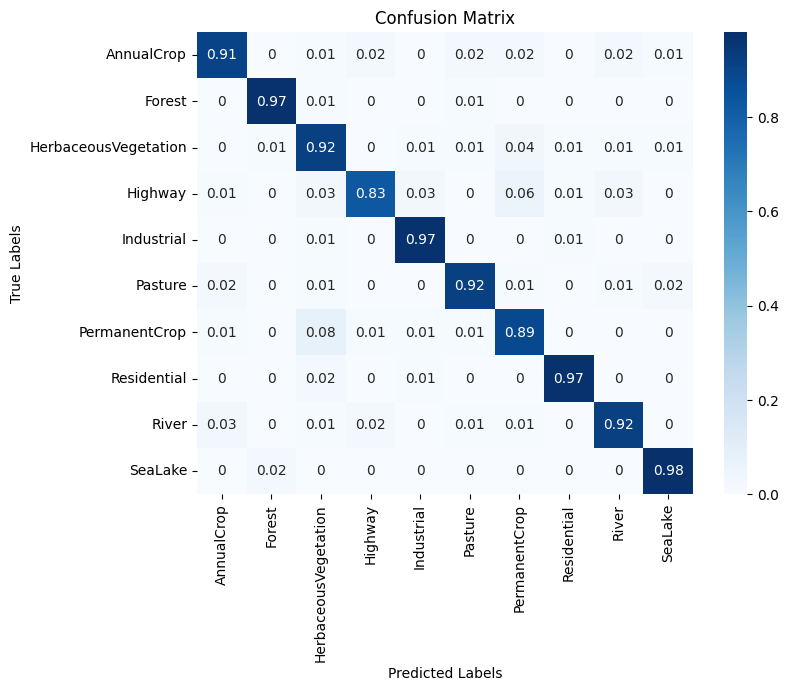

In [45]:
# The confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns


confusion_matrix_result = confusion_matrix(true_labels, predicted_labels)
confusion_matrix_result = np.round(confusion_matrix_result.astype('float') / confusion_matrix_result.sum(axis=1)[:, np.newaxis], 2)
classes = encoder.categories_[0]

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_result, annot=True, cmap='Blues', fmt='g', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


Accuracy for AnnualCrop: 90.10%
Accuracy for Forest: 97.98%
Accuracy for HerbaceousVegetation: 90.20%
Accuracy for Highway: 83.00%
Accuracy for Industrial: 97.98%
Accuracy for Pasture: 92.93%
Accuracy for PermanentCrop: 88.12%
Accuracy for Residential: 97.00%
Accuracy for River: 92.00%
Accuracy for SeaLake: 98.00%


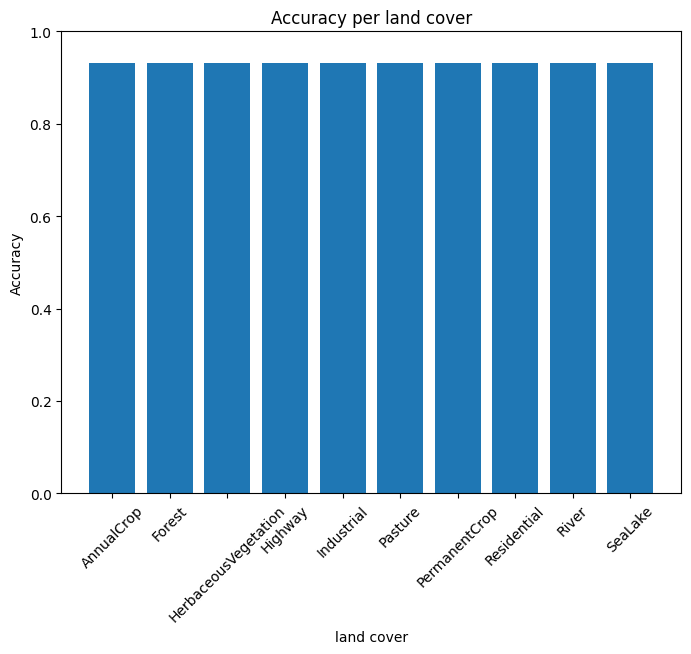

In [46]:
#  Accuracy per class

num_classes = len(classes)
accuracy_per_class = [confusion_matrix_result[i, i] / np.sum(confusion_matrix_result[i, :]) for i in range(num_classes)]

for i, label in enumerate(classes):
    print(f'Accuracy for {label}: {accuracy_per_class[i]*100:.2f}%')


plt.figure(figsize=(8, 6))
plt.bar(classes, accuracy)
plt.xlabel('land cover')
plt.ylabel('Accuracy')
plt.title('Accuracy per land cover')
plt.ylim([0, 1])
plt.xticks(rotation=45)
plt.show()


# **ResNet Model**

In [47]:
import torch
import torch.nn as nn
from torchvision.models import resnet50

class ResNet50(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet50, self).__init__()
        # Load the pre-trained ResNet-50 model
        self.resnet = resnet50(pretrained=True)

        # Freeze layers
        for param in self.resnet.parameters():
            param.requires_grad = False

        # Replace the fully connected layer with a custom one for the specific number of classes
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
        nn.Linear(num_ftrs, 128),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.resnet(x)

# Creating an instance of the ResNet50Custom model
model2 = ResNet50().to(device)

# Print the model architecture
#print(model2)


# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()

lr = 0.001
w_d = 1e-4

optimizer = optim.Adam(model2.parameters(), lr=lr, weight_decay=w_d)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

# Training loop
num_epochs = 40
batch_size=64

train_dataset = TensorDataset(X_train_tensor, y_train_tensor.argmax(dim=1))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor.argmax(dim=1))
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 1/40, Training Loss: 0.073, Validation Loss: 0.203, Accuracy: 93.53%
Epoch 2/40, Training Loss: 0.062, Validation Loss: 0.193, Accuracy: 94.08%
Epoch 3/40, Training Loss: 0.061, Validation Loss: 0.186, Accuracy: 94.40%
Epoch 4/40, Training Loss: 0.057, Validation Loss: 0.178, Accuracy: 94.47%
Epoch 5/40, Training Loss: 0.052, Validation Loss: 0.175, Accuracy: 94.58%
Epoch 6/40, Training Loss: 0.050, Validation Loss: 0.177, Accuracy: 94.42%
Epoch 7/40, Training Loss: 0.050, Validation Loss: 0.176, Accuracy: 94.47%
Epoch 8/40, Training Loss: 0.050, Validation Loss: 0.171, Accuracy: 94.70%
Epoch 9/40, Training Loss: 0.048, Validation Loss: 0.171, Accuracy: 94.85%
Epoch 10/40, Training Loss: 0.049, Validation Loss: 0.174, Accuracy: 94.58%
Epoch 11/40, Training Loss: 0.048, Validation Loss: 0.173, Accuracy: 94.75%
Epoch 12/40, Training Loss: 0.049, Validation Loss: 0.171, Accuracy: 94.65%
Epoch 13/40, Training Loss: 0.048, Validation Loss: 0.173, Accuracy: 94.75%
Epoch 14/40, Training

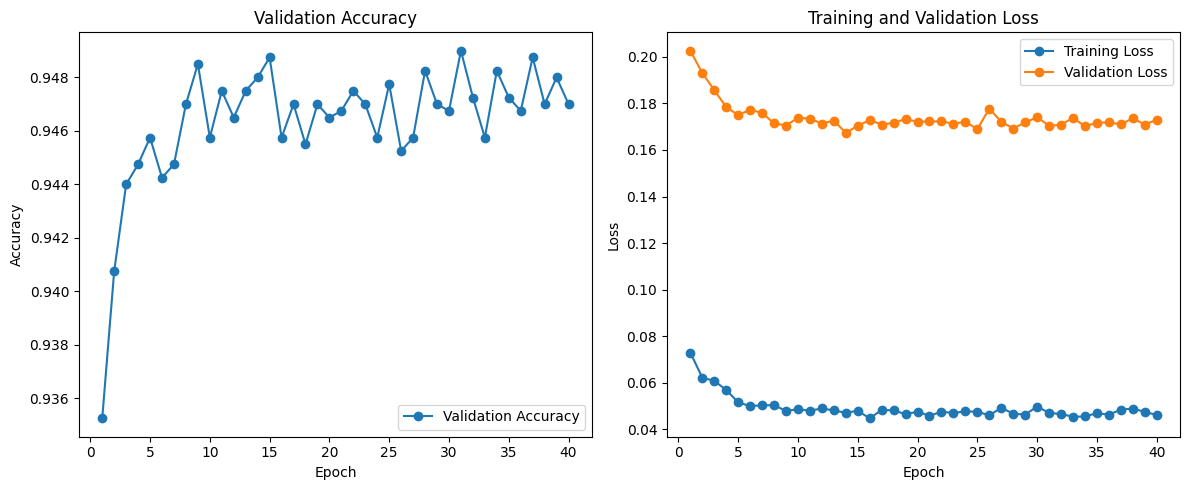

In [48]:

train_losses = []
valid_losses = []
accuracies = []

for epoch in range(num_epochs):
    # Training phase
    scheduler.step()
    model2.train()
    model.train()
    train_loss = 0.0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = (model2(inputs) + model(inputs)) / 2
        loss = criterion(outputs, labels)
        train_loss += loss.item()  # Accumulate the training loss
        loss.backward()
        optimizer.step()

    # Normalize the training loss
    train_losses.append(train_loss / len(train_loader))

    # Validation phase
    model2.eval()
    model.eval()
    valid_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = (model2(inputs) + model(inputs)) / 2
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    # Normalize the validation loss and calculate accuracy
    valid_losses.append(valid_loss / len(valid_loader))
    accuracies.append(correct / total)

    print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_losses[-1]:.3f}, Validation Loss: {valid_losses[-1]:.3f}, Accuracy: {100*accuracies[-1]:.2f}%')

# After training, plot the learning curves
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracies, 'o-', label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses, 'o-', label='Training Loss')
plt.plot(epochs, valid_losses, 'o-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [50]:
from sklearn.metrics import precision_recall_fscore_support

# Calculate precision, recall, F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1_score:.4f}')


Precision: 0.9315
Recall: 0.9305
F1-score: 0.9304


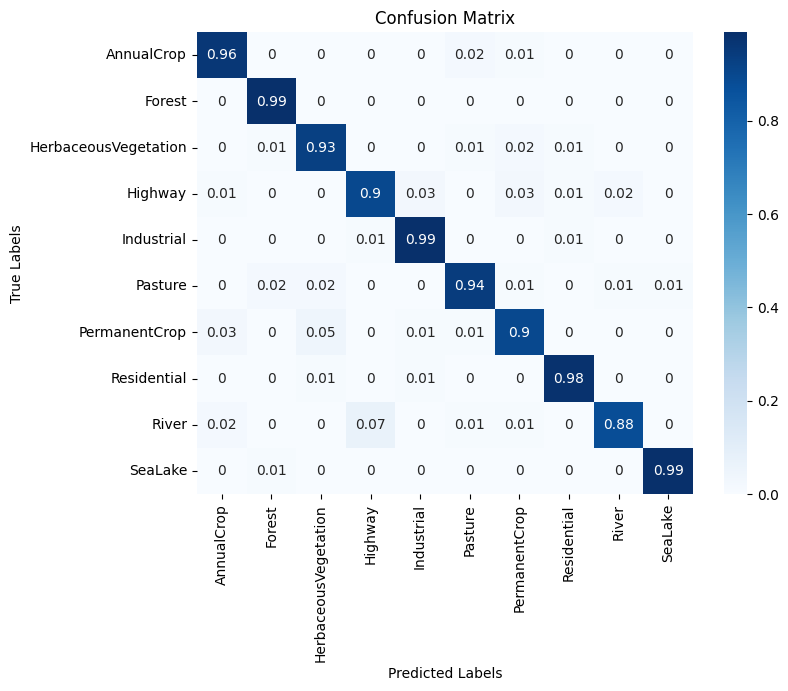

In [19]:
# The confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns


confusion_matrix_result = confusion_matrix(true_labels, predicted_labels)
confusion_matrix_result = np.round(confusion_matrix_result.astype('float') / confusion_matrix_result.sum(axis=1)[:, np.newaxis], 2)
classes = encoder.categories_[0]

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_result, annot=True, cmap='Blues', fmt='g', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


Accuracy for AnnualCrop: 96.97%
Accuracy for Forest: 100.00%
Accuracy for HerbaceousVegetation: 94.90%
Accuracy for Highway: 90.00%
Accuracy for Industrial: 98.02%
Accuracy for Pasture: 93.07%
Accuracy for PermanentCrop: 90.00%
Accuracy for Residential: 98.00%
Accuracy for River: 88.89%
Accuracy for SeaLake: 99.00%


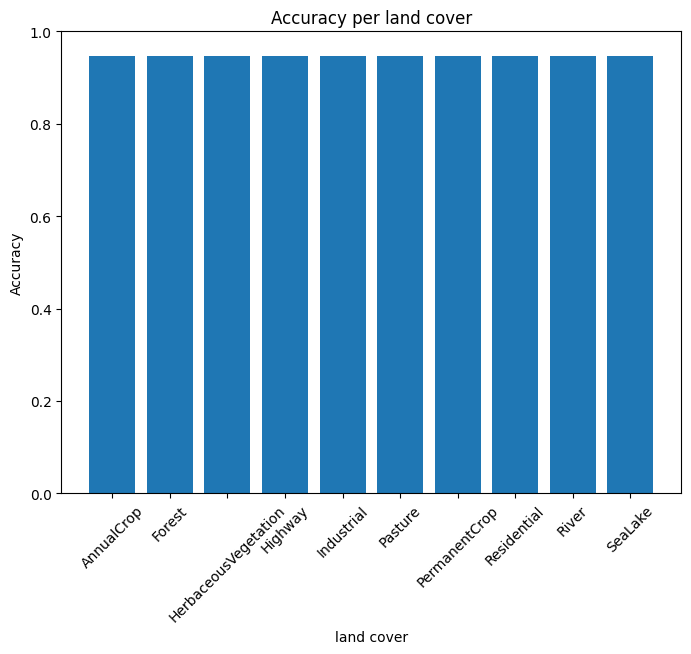

In [20]:
#  Accuracy per class

num_classes = len(classes)
accuracy_per_class = [confusion_matrix_result[i, i] / np.sum(confusion_matrix_result[i, :]) for i in range(num_classes)]

for i, label in enumerate(classes):
    print(f'Accuracy for {label}: {accuracy_per_class[i]*100:.2f}%')


plt.figure(figsize=(8, 6))
plt.bar(classes, accuracy)
plt.xlabel('land cover')
plt.ylabel('Accuracy')
plt.title('Accuracy per land cover')
plt.ylim([0, 1])
plt.xticks(rotation=45)
plt.show()


In [21]:
#F1-score ,recall and precision for each class

precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels, predicted_labels, average=None)

# Print metrics for each class
for class_index in range(len(precision)):
    print(f'Class {class_index + 1}:')
    print(f'  Precision: {precision[class_index]:.4f}')
    print(f'  Recall: {recall[class_index]:.4f}')
    print(f'  F1-score: {f1_score[class_index]:.4f}')
    print()

Class 1:
  Precision: 0.9468
  Recall: 0.9591
  F1-score: 0.9529

Class 2:
  Precision: 0.9671
  Recall: 0.9888
  F1-score: 0.9778

Class 3:
  Precision: 0.9276
  Recall: 0.9297
  F1-score: 0.9286

Class 4:
  Precision: 0.9155
  Recall: 0.8984
  F1-score: 0.9069

Class 5:
  Precision: 0.9412
  Recall: 0.9860
  F1-score: 0.9631

Class 6:
  Precision: 0.9381
  Recall: 0.9381
  F1-score: 0.9381

Class 7:
  Precision: 0.9073
  Recall: 0.8997
  F1-score: 0.9035

Class 8:
  Precision: 0.9698
  Recall: 0.9766
  F1-score: 0.9732

Class 9:
  Precision: 0.9505
  Recall: 0.8771
  F1-score: 0.9123

Class 10:
  Precision: 0.9865
  Recall: 0.9865
  F1-score: 0.9865



# Create Your Submission

In [51]:
# Function to create a submission file
def create_submission(name,predictions):
    assert predictions.shape == (7000, 1), f"Wrong shape for your prediction file : {predictions.shape} instead of (7000, 1)"
    with open(name +'.npy', 'wb') as f:
      np.save(f, predictions)
    print("File predictions.npy created !")

In [52]:
# Use the following code in the submission cell of your project notebook
# Generate predictions
bs = 35
predictions = np.ones((X_test_tensor.shape[0],10))
for i in range(X_test_tensor.shape[0]//bs):
  predictions[bs*i:bs*(i+1),:] = model(X_test_tensor[bs*i:bs*(i+1)].to(device)).cpu().detach().numpy()
print(predictions[:5])

# Get labels
predictions = encoder.inverse_transform(predictions)
print(predictions[:5])

# Create a submission using the provided function
NAME = "OUSSAKEL"
from datetime import datetime
# Get the current date
current_date = datetime.now()
# Format the date as MM_DD_YY
formatted_date = current_date.strftime("%m_%d_%y")

create_submission(f"{NAME}_{formatted_date}",predictions)

[[ -2.23774362  -1.8341018   -4.18068266  -9.31349087 -20.69030952
   22.00281143 -12.43451309 -20.23856735  -3.66272235  -6.19819641]
 [ -8.30360317 -11.86456871  -6.57864714   2.26224089  14.40398979
  -14.12609959  -3.67814708   0.34521317  -2.16222668  -8.91620541]
 [ -0.66949618  -9.1708231    1.17069066  -1.91408396  -6.07412148
   -6.63274765  12.87446117  -8.35493279  -8.60509014 -13.25137329]
 [ -5.31659269  11.78881931  -5.36314154 -13.49923611  -9.24045658
   -3.63767791  -5.62996578  -7.08161783  -0.11771157  -1.7466079 ]
 [ -5.56759357  -4.23386478  -5.43310308  -3.72328758  -9.57921124
   -2.06110263 -11.666049   -12.07922363  15.81709862  -2.31791186]]
[['Pasture']
 ['Industrial']
 ['PermanentCrop']
 ['Forest']
 ['River']]
File predictions.npy created !


In [ ]:
from google.colab import drive
drive.mount('/content/drive')